Dataset shape: (4465, 242)
   ACCESS_ALL_DOWNLOADS  ACCESS_CACHE_FILESYSTEM  ACCESS_CHECKIN_PROPERTIES  \
0                   0.0                      0.0                        0.0   
1                   0.0                      0.0                        0.0   
2                   0.0                      0.0                        0.0   
3                   0.0                      0.0                        0.0   
4                   0.0                      0.0                        0.0   

   ACCESS_COARSE_LOCATION  ACCESS_COARSE_UPDATES  ACCESS_FINE_LOCATION  \
0                     0.0                    0.0                   0.0   
1                     0.0                    0.0                   0.0   
2                     0.0                    0.0                   0.0   
3                     0.0                    0.0                   0.0   
4                     0.0                    0.0                   0.0   

   ACCESS_LOCATION_EXTRA_COMMANDS  ACCESS_MOCK_LOCATI

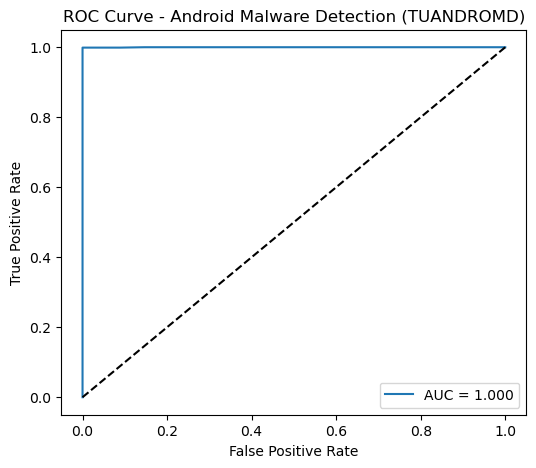

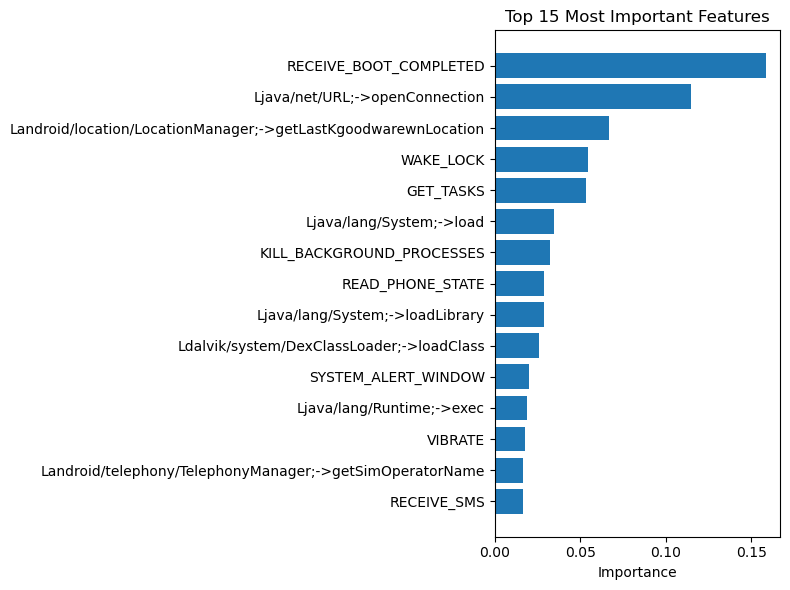


Saved model and scaler successfully.


In [10]:
# ANDROID MALWARE DETECTION 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# 1. Load dataset

df = pd.read_csv("/Users/harsha/Downloads/TUANDROMD.csv")
print("Dataset shape:", df.shape)
print(df.head())

# 2. Clean Label column 

df["Label"] = df["Label"].astype(str).str.lower().str.strip()
print("\nRaw label values & counts:")
print(df["Label"].value_counts())

df = df[df["Label"].isin(["malware", "goodware"])].copy()

label_map = {"goodware": 0, "malware": 1}
df["Label"] = df["Label"].map(label_map)

assert df["Label"].isna().sum() == 0, "There are NaNs in Label after mapping!"
df["Label"] = df["Label"].astype(int)

print("\nCleaned label counts:")
print(df["Label"].value_counts())
print("Label dtype:", df["Label"].dtype)

# 3. Handle missing values in features

df = df.fillna(0)

# 4. Split features / target and scale

X = df.drop(columns=["Label"])
y = df["Label"]

X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

print("\nX shape:", X.shape, " | y shape:", y.shape)
print("Unique y values:", y.unique())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Stratified train/test split 

class_counts = y.value_counts()
print("\nClass counts before split:\n", class_counts)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y   # now only ints 0/1
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

# 6. Model Training

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# 7. Evaluation

y_pred = rf.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# 8. ROC Curve

y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve - Android Malware Detection (TUANDROMD)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 9. Feature Importance

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # top 15

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 15 Most Important Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 10. Save Model + Scaler

joblib.dump(rf, "android_malware_rf_model.joblib")
joblib.dump(scaler, "android_malware_scaler.joblib")

print("\nSaved model and scaler successfully.")
